# HAB Capstone Modeling 

## Contents:
[1. Introduction and Data Loading](#1)
 
[2. Linear Regression](#2)
 
[3. Ensemble Methods - Regression, Scaled Features](#3)
* [3.a. Random Forest Regressor](#3a)
* [3.b. XGBoost Regressor](#3b)
 
 
[4. Ensemble Methods - Regression, Unscaled Features](#4)
* [4.a. Random Forest Regressor](#4a)
* [4.b. XGBoost Regressor](#4b)
 
[5. Binary Classification with Ensemble Methods](#5)
* [5.a. Random Forest Classification](#5a)
* [5.b. XGBoost Classification](#5b)

[6. Model Recommendation and Feature Importance](#6)

In [1]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, recall_score, roc_auc_score, plot_roc_curve, precision_recall_curve
from sklearn.metrics import plot_confusion_matrix, precision_recall_fscore_support, plot_precision_recall_curve
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV, cross_val_score, train_test_split, TimeSeriesSplit

import xgboost as xgb

import sys
sys.path.append('../src/')
from visualization.visualize import *

#set random seed for reproducibility
np.random.seed(seed=42)

## <a id='1'>1. Introduction and Data Loading</a>

The goal of this notebook is to train and test machine learning models for the purpose of predicting harmful algal bloom (HAB) events in the Western Basin of Lake Erie. The problem will be first approached as a regression problem to see if we can predict the microcystin concentration at a given location on a given day, then as a classification problem to see if we could predict various classes of microcystin concentration using the Ohio EPA cutoff values:
    <ul>
    <li>drinking limit - 1.6 µg/L</li>
    <li>recreation limit - 6 µg/L</li>
    <li>strict no-contact limit - 20 µg/L</li>
    </ul>
Finally we will also performed binary classification to sort samples into low and high microcystin classes using the Ohio EPA drinking limit of 1.6 µg/L as a cutoff value.

Data were originally sampled with weekly or biweekly frequency depending on the site and year. The data were upsampled to daily frequency with linear interpolation in order to apply time shifts to the features before downsampling to weekly frequency. For the scaled feature set skewed features were first log-transformed and then standardized. Features such as temperature and dissolved oxygen that were not heavily skewed were simply standardized. The final scaled features were then split into training and testing sets with a test size of 0.2. Please see the feature engineering notebook for details. 

In [2]:
#load unscaled data
unscaled = pd.read_csv('../data/processed/resampled_unscaled.csv', index_col=0)

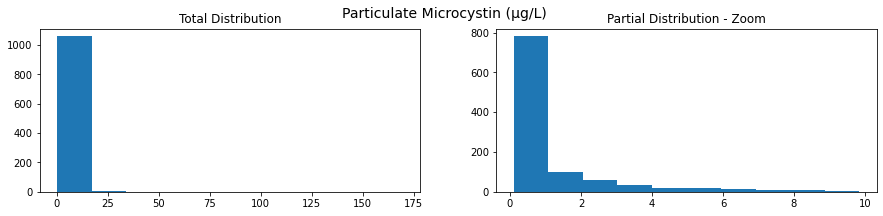

In [3]:
#visualize particulate microcystin distribution
hist_zoom(unscaled, 'Particulate Microcystin (µg/L)', cutoff=10)

In [4]:
print('All Measurements:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 0))
print('Greater than 1.6 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 1.6))
print('Greater than 6 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 6))
print('Greater than 20 µg/L:', sum(unscaled['Particulate Microcystin (µg/L)'] >= 20))

All Measurements: 1073
Greater than 1.6 µg/L: 229
Greater than 6 µg/L: 59
Greater than 20 µg/L: 12


As you can see from the histogram, the majority of measurements are between 0 µg/L and 1.6 µg/L. The most extreme cases of particulate microcystin greater than 20 µg/L only constitute 1.1% of all measurements.

In [5]:
#load scaled data
X_train_df = pd.read_csv('../data/processed/resampled_Xtrain.csv', index_col=0)
X_test_df = pd.read_csv('../data/processed/resampled_Xtest.csv', index_col=0)
y_train_df = pd.read_csv('../data/processed/resampled_ytrain.csv', index_col=0)
y_test_df = pd.read_csv('../data/processed/resampled_ytest.csv', index_col=0)

X_train = X_train_df.values
X_test = X_test_df.values
y_train = y_train_df.values.flatten()
y_test = y_test_df.values.flatten()

In [6]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 858 entries, 0 to 857
Data columns (total 27 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Distance from Maumee Inlet (km)            858 non-null    float64
 1   Shore Distance (euc dis)                   858 non-null    float64
 2   CTD Temperature (°C)_2wks                  858 non-null    float64
 3   CTD Temperature (°C)_4wks                  858 non-null    float64
 4   CTD Temperature (°C)_6wks                  858 non-null    float64
 5   CTD Dissolved Oxygen (mg/L)_2wks           858 non-null    float64
 6   CTD Dissolved Oxygen (mg/L)_4wks           858 non-null    float64
 7   CTD Dissolved Oxygen (mg/L)_6wks           858 non-null    float64
 8   Total Phosphorus (µg P/L)_2wks             858 non-null    float64
 9   Total Phosphorus (µg P/L)_4wks             858 non-null    float64
 10  Total Phosphorus (µg P/L)_

## <a id='2'>2. Linear Regression</a>

We will start with basic ordinary least squares regression.

In [7]:
ols = LinearRegression()
ols.fit(X_train, y_train)
ols.score(X_train, y_train)

0.470010664927936

In [8]:
def model_test_plot(model, X_test, y_test, name='Model', value='Value', savefig=False, fname='fig'):
    
    """Expects a fitted model. Predicts outputs for a test set and plots predicted values vs true 
    values in a scatterplot. Also returns the mean average prediction error."""
    fig, ax = plt.subplots()
    y_pred = model.predict(X_test)
    x = np.linspace(min(y_test), max(y_test), 50)
    y = x
    ax.plot(x, y, '-r', label='perfect prediction')
    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.legend()
    plt.xlabel('True ' + value)
    plt.ylabel('Predicted ' + value)
    plt.title(name + ' Results - Testing Data')
    if savefig:
        fpath = '../reports/figures/' + fname + '.jpg'
        fig.savefig(fpath)
    plt.show()
    mae = mean_absolute_error(y_test, y_pred)
    
    return mae

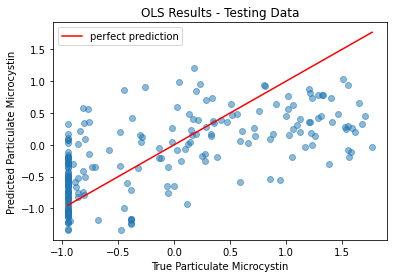

0.5386674074111638

In [9]:
model_test_plot(ols, X_test, y_test, name='OLS', value='Particulate Microcystin', savefig=True, fname='ols_test_plot')

The OLS model shows poor performance with a mean absolute errors of approximately 0.54. The model also shows overestimation of low values and underestimation of high values, as expected due to regression to the mean. It is clear that linear models are far too underpowered for this problem so we will move on to ensemble methods.

## <a id='3'>3. Ensemble Methods - Regression, Scaled Data</a>
### <a id='3a'>3.a. Random Forest Regressor</a>

We will use random search in order to tune hyperparameters for the Random Forest (RF) model. Since the data is ordered in time we will use a time series split to ensure that testing sets always occur chronologically after the training sets. This means that the first training set will be significantly smaller than the second and third, which may impact scoring on the first few sets. However, this way we can be sure to avoid bias from giving the model access to future data.

In [14]:
#perform randomized hyperparameter search for comparison
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf = RandomForestRegressor()
tss = TimeSeriesSplit(n_splits=3)
rfcv = RandomizedSearchCV(rf, params, cv=tss, verbose=1, n_jobs=-1)

rfcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   20.8s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=1)

In [15]:
#examine randomized search outputs
pd.DataFrame(rfcv.cv_results_).sort_values('rank_test_score').T

,7,5,0,4,8,2,1,6,3,9
mean_fit_time,1.46574,1.14475,0.694742,2.16684,6.11957,5.46767,1.4075,1.45029,2.6445,2.99138
std_fit_time,0.480042,0.360267,0.145426,0.872822,1.43823,0.654004,0.130313,0.24359,0.34254,0.083696
mean_score_time,0.0316656,0.0419723,0.0316303,0.0521886,0.100459,0.285251,0.0453614,0.0429993,0.153594,0.0981956
std_score_time,0.00758458,0.00722117,0.00365498,0.0132423,0.0288088,0.0841289,0.00222973,0.000848819,0.0462382,0.0213186
param_n_estimators,100,100,100,200,500,1000,200,200,500,500
param_min_samples_split,2,10,4,10,10,4,4,4,4,10
param_min_samples_leaf,1,4,1,4,1,4,1,1,4,1
param_max_features,auto,auto,sqrt,auto,auto,sqrt,sqrt,sqrt,sqrt,sqrt
param_max_depth,100,None,100,100,10,None,10,100,10,None
params,"{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 100, 'min_samples_split': 10,...","{'n_estimators': 100, 'min_samples_split': 4, ...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 500, 'min_samples_split': 10,...","{'n_estimators': 1000, 'min_samples_split': 4,...","{'n_estimators': 200, 'min_samples_split': 4, ...","{'n_estimators': 200, 'min_samples_split': 4, ...","{'n_estimators': 500, 'min_samples_split': 4, ...","{'n_estimators': 500, 'min_samples_split': 10,..."


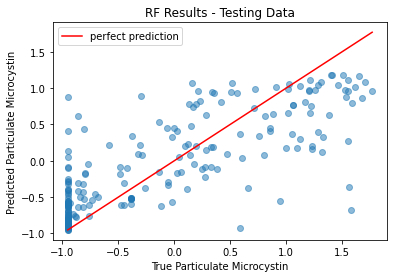

0.40979963297189326

In [16]:
rf_best = rfcv.best_estimator_
rf_best.fit(X_train, y_train)
model_test_plot(rf_best, X_test, y_test, name='RF', value='Particulate Microcystin', savefig=True, fname='rf_test_plot')

The RF model performs slightly better than OLS with a mean absolute error of 0.41. However there are still huge variations in predictions for given true concentrations of microcystin, and high values in particular are quite underestimated. Let's try an XGBoost model for comparison.

### <a id='3b'>3.b. XGBoost Regressor</a>

In [17]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr = xgb.XGBRegressor()
xgbcv = RandomizedSearchCV(xgbr, params, cv=tss, verbose=1, n_jobs=-1)

xgbcv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.3s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=na...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
        

In [18]:
pd.DataFrame(xgbcv.cv_results_).sort_values('rank_test_score').T

,4,5,1,9,3,2,0,8,6,7
mean_fit_time,0.228743,0.274341,0.05106,0.143664,0.0936646,0.069864,0.3429,0.115386,0.0474864,0.0588451
std_fit_time,0.0975701,0.121178,0.0118115,0.0351558,0.0376913,0.0318421,0.147347,0.0450752,0.0167679,0.0223454
mean_score_time,0.00291268,0.00235669,0.00220402,0.00211493,0.00231504,0.00217271,0.00285888,0.0021023,0.00217899,0.00223422
std_score_time,0.000129571,0.000125169,8.2959e-05,0.000240813,7.52013e-05,5.48974e-05,0.000190752,0.000325291,4.21789e-05,3.85487e-05
param_n_estimators,50,50,10,50,20,10,50,20,10,10
param_min_child_weight,5,5,3,0.5,5,0.5,5,1,0.5,1
param_max_depth,None,10,50,None,None,100,50,100,None,100
param_learning_rate,0.1,0.3,0.3,0.1,0.2,0.1,0.01,0.01,0.01,0.01
param_gamma,0,0.5,1,0.5,0.25,0.5,1,1,1,0
param_colsample_bytree,1,0.8,0.5,0.8,1,0.8,1,0.8,0.8,0.7


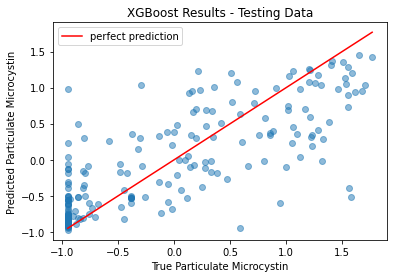

0.38896001177323597

In [19]:
xgbr_best = xgbcv.best_estimator_
xgbr_best.fit(X_train, y_train)
model_test_plot(xgbr_best, X_test, y_test, name='XGBoost', value='Particulate Microcystin', savefig=True, fname='xgb_test_plot')

The XGBoost model performs slightly better than the RF model with a mean absolute error of 0.39, which is still quite poor performance. Additionally the large errors in high particulate microcystin concentrations on the log-transformed data will correspond to even larger absolute errors on the original data. 

## <a id='4'>4. Ensemble Methods - Regression, Unscaled Features</a>
### <a id='4a'>4.a. Random Forest Regressor</a>

Since decision trees use single splits to determine outcomes they don't depend on scaling in principal. However, scaling will affect the optimization of a decision tree for a regression problem since varying transformations will affect the magnitude of the residuals. Given the poor performance of scaled features especially for large microcystin concentrations we will explore unscaled features here. 

In [20]:
#select past features and separate into training and testing split
X_unscaled = unscaled.drop(columns='Particulate Microcystin (µg/L)').values
y_unscaled = unscaled['Particulate Microcystin (µg/L)'].values

X_us_train, X_us_test, y_us_train, y_us_test = train_test_split(X_unscaled, y_unscaled, test_size=0.2, shuffle=False)

In [23]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rf_us = RandomForestRegressor()
rf_us_cv = RandomizedSearchCV(rf_us, params, cv=tss, verbose=1, n_jobs=-1)

rf_us_cv.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   22.4s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   verbose=1)

In [24]:
#examine output
pd.DataFrame(rf_us_cv.cv_results_).sort_values('rank_test_score').T

,5,4,1,0,8,9,6,7,3,2
mean_fit_time,0.523093,2.58458,5.3129,5.87061,5.67198,1.13512,0.898571,1.3647,1.24149,2.70433
std_fit_time,0.0231616,0.316135,0.490952,0.761001,0.386652,0.170794,0.124939,0.665605,0.405073,1.24193
mean_score_time,0.0216711,0.098091,0.227605,0.201932,0.174586,0.0434318,0.04519,0.034342,0.028705,0.0493709
std_score_time,0.00075514,0.00277944,0.0197725,0.0051528,0.0322383,0.0072578,0.00469751,0.0142927,0.00717817,0.010573
param_n_estimators,100,500,1000,1000,1000,200,200,100,100,200
param_min_samples_split,2,10,4,10,4,10,10,10,2,2
param_min_samples_leaf,4,4,4,1,1,1,1,4,4,4
param_max_features,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,sqrt,auto,auto,auto
param_max_depth,100,50,10,100,50,None,10,None,10,100
params,"{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 500, 'min_samples_split': 10,...","{'n_estimators': 1000, 'min_samples_split': 4,...","{'n_estimators': 1000, 'min_samples_split': 10...","{'n_estimators': 1000, 'min_samples_split': 4,...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 200, 'min_samples_split': 10,...","{'n_estimators': 100, 'min_samples_split': 10,...","{'n_estimators': 100, 'min_samples_split': 2, ...","{'n_estimators': 200, 'min_samples_split': 2, ..."


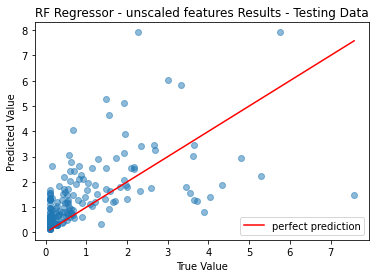

0.7400317547252705

In [25]:
#fit best estimator and calculate mean absolute error of the training set.
rf_us_best = rf_us_cv.best_estimator_
rf_us_best.fit(X_us_train, y_us_train)
model_test_plot(rf_us_best, X_test=X_us_test, y_test=y_us_test, name='RF Regressor - unscaled features',
                savefig=True, fname='rf_us_regression')

The RF regressor has an MAE of 0.74 µg/L on the test set and seems to underestimate elevated concentrations of microcystin. Overall the RF regressor cannot distinguish between low and high concentrations.

### <a id='4b'>4.a. XGBoost Regressor</a>

In [32]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

xgbr_us = xgb.XGBRegressor()

xgbcv_us = RandomizedSearchCV(xgbr_us, params, cv=tss, verbose=1, n_jobs=-1)

xgbcv_us.fit(X_us_train, y_us_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   12.8s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=na...
                                          reg_lambda=None,
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
        

In [33]:
#examine random search results
pd.DataFrame(xgbcv_us.cv_results_).sort_values('rank_test_score').T

,8,5,3,0,2,6,4,9,1,7
mean_fit_time,0.732377,0.435259,0.223826,0.135607,0.344227,0.697664,0.106679,0.595751,1.46673,0.887734
std_fit_time,0.401445,0.212754,0.160208,0.0385121,0.0933303,0.148436,0.0318902,0.292747,0.530349,0.372547
mean_score_time,0.00404231,0.0112733,0.00241669,0.00553966,0.00572395,0.00312273,0.00255672,0.00414928,0.00261529,0.00245094
std_score_time,0.000835159,0.0120055,8.15864e-05,0.00301384,0.00291575,0.000281758,0.00011716,0.00035998,0.000131862,0.00010192
param_n_estimators,100,50,20,10,50,50,20,100,100,50
param_min_child_weight,3,0.5,3,0.5,3,1,0.5,0.5,0.5,1
param_max_depth,None,None,50,None,None,10,None,10,10,100
param_learning_rate,0.001,0.001,0.001,0.001,0.01,0.01,0.1,0.3,0.3,0.3
param_gamma,0.5,1,1,0.5,1,0.5,0,0,0.5,0.25
param_colsample_bytree,0.9,0.9,0.9,0.7,0.8,0.9,0.7,0.7,1,0.8


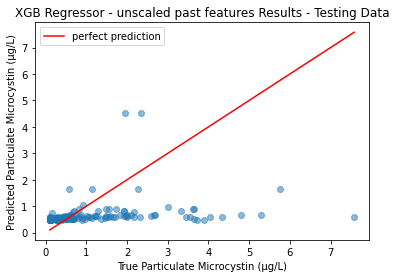

0.6627249143470085

In [34]:
xgbus_best = xgbcv_us.best_estimator_
xgbus_best.fit(X_us_train, y_us_train)
model_test_plot(xgbus_best, X_us_test, y_us_test, name='XGB Regressor - unscaled past features', 
                value='Particulate Microcystin (µg/L)', savefig=True, fname='xgb_us_regression')

Here the XGBoost model has a slightly better MAE than the RF regressor (0.66 µg/L on the test set). However this is clearly because the model mostly predicts a low concentration for all points. It is again unable to distinguish between low and elevated microcystin concentrations.

While it would be nice to have a prediction that estimates exact microcystin concentration our goals pertain more to accurate identification and prediction of high concentration samples as a class. Therefore it may be better, and hopefully more effective, to approach this as a classification problem. From an application and policy standpoint the response to a concentration of 8 µg/L versus 6 µg/L is much the same, what is really important is predicting where a sample will fall in the spectrum of EPA concentration categories.

## <a id='5'>5. Binary Classification with Ensemble Methods</a>
### <a id='5a'>5.a. Random Forest Classifier</a>

We will start with binary classification. Although there is not a particular cutoff for particulate microcystin that indicates the definitive presence of a harmful algal bloom we can reasonably use the EPA drinking cutoff of 1.6 µg/L.

In [37]:
#define function for sorting particulate microcystin concentrations into categories
def pm_bin(pm):
    if pm < 1.6:
        return 0
    else:
        return 1

y_bin = unscaled['Particulate Microcystin (µg/L)'].apply(lambda x: pm_bin(x)).values
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_unscaled, y_bin, test_size=0.2, shuffle=False)

In [38]:
print(sum(y_bin == 0), 'samples below 1.6 µg/L')
print(sum(y_bin == 1), 'samples at or above 1.6 µg/L')

844 samples below 1.6 µg/L
229 samples at or above 1.6 µg/L


The classes are fairly imbalanced so we will use balanced accuracy as a scoring metric to incentivize identifying higher particulate microcystin samples.

In [40]:
#perform randomized hyperparameter search on unscaled features
params = {
 'max_depth': [None, 10, 50, 100],
 'criterion': ['gini', 'entropy'],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 4],
 'min_samples_split': [2, 4, 10],
 'n_estimators': [100, 200, 500, 1000]
}
rfbin = RandomForestClassifier()
rfbin_cv = RandomizedSearchCV(rfbin, params, cv=tss, verbose=1, n_jobs=-1, scoring='balanced_accuracy')

rfbin_cv.fit(X_bin_train, y_bin_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   23.5s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 50, 100],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 4, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   scoring='balanced_accuracy', verbose=1)

In [41]:
#examine cv results
pd.DataFrame(rfbin_cv.cv_results_).sort_values('rank_test_score').T

,8,4,2,7,1,6,9,5,0,3
mean_fit_time,2.48394,0.453386,5.37646,2.41127,2.78443,4.69624,2.16087,1.05091,1.43288,5.00534
std_fit_time,0.276461,0.0530452,0.7244,0.352302,0.146321,0.538484,0.118006,0.211755,0.383485,0.824568
mean_score_time,0.122841,0.0275149,0.254625,0.137183,0.140124,0.256968,0.0988804,0.0540076,0.171543,0.257229
std_score_time,0.00749889,0.000802268,0.00299244,0.0118425,0.00759025,0.0035326,0.0220891,0.00289489,0.156757,0.00144599
param_n_estimators,500,100,1000,500,500,1000,500,200,200,1000
param_min_samples_split,4,4,4,10,4,10,2,10,10,10
param_min_samples_leaf,1,1,1,1,4,4,4,1,4,4
param_max_features,sqrt,auto,auto,auto,auto,auto,auto,auto,sqrt,auto
param_max_depth,50,10,100,50,50,None,None,None,100,10
param_criterion,gini,gini,entropy,gini,gini,gini,entropy,entropy,entropy,entropy


In [42]:
rfbin_best = rfbin_cv.best_estimator_
rfbin_best.fit(X_bin_train, y_bin_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=4,
                       n_estimators=500)

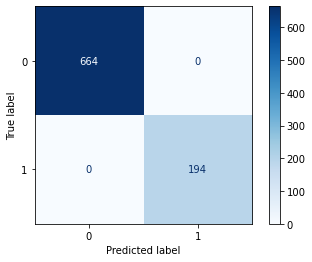

In [43]:
plot_confusion_matrix(rfbin_best, X_bin_train, y_bin_train, cmap='Blues')
plt.show()

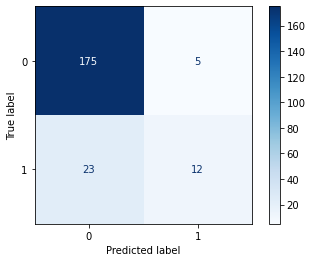

In [44]:
plot_confusion_matrix(rfbin_best, X_bin_test, y_bin_test, cmap='Blues')
plt.show()

In [45]:
pd.DataFrame(precision_recall_fscore_support(y_bin_test, rfbin_best.predict(X_bin_test)), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.883838,0.705882
Recall,0.972222,0.342857
Fscore,0.925926,0.461538
Support,180.000000,35.000000


The RF binary classifier is able to catch 34% of the samples with concentrations above 1.6 µg/L. This is very poor performance but it can distinguish somewhat between very low concentrations and elevated concentrations of particulate microcystin. Recall is the most notable metric for our application since our goal is to identify all HAB events. A false-positive event is an annoyance, but not predicting a bloom that then happens is more detrimental. If the baseline model were to guess randomly using the positive weight as the probability that a sample is a high concentration then we would expect a recall of 52/(52+163) = 0.24, so it is only slightly better than the recall relative to guessing.

We hope to use this data to predict microcystin values in future seasons. We expect that ecological dynamics could meaningfully change from one year to the next, which would decrease the effectiveness of the model from year to year. This can be checked using time series split cross-validation.

In [46]:
#check for consistency across unshuffled cross-validation splits.
cvs = cross_val_score(rfbin_best, X_unscaled, y_bin, cv=tss, scoring='recall')
print('Average recall:', np.mean(cvs), '\n' + 'Std recall:' + str(np.std(cvs)))

cvs = cross_val_score(rfbin_best, X_unscaled, y_bin, cv=tss, scoring='precision')
print('Average precision:', np.mean(cvs), '\n' + 'Std precision:' + str(np.std(cvs)))

Average recall: 0.4758149793045107 
Std recall:0.09380010509485832
Average precision: 0.751395947048121 
Std precision:0.04130009626098236


We can look at tuning the model's recall by sacrificing precision with a precision / recall curve. Again, recall is more important than precision for our application since our goal is to warn of impending algal blooms, and a false positive is just an annoyance while a false negative is a missed warning. We can perhaps adjust the model thresholds to improve recall while accepting worse precision. In order to do this we will need to make a training and testing split from our original traning set.

In [53]:
X_thresh_train, X_thresh_test, y_thresh_train, y_thresh_test = train_test_split(X_bin_train, y_bin_train, test_size=0.2, shuffle=False)
rfbin_best.fit(X_thresh_train, y_thresh_train)

RandomForestClassifier(max_depth=50, max_features='sqrt', min_samples_split=4,
                       n_estimators=500)

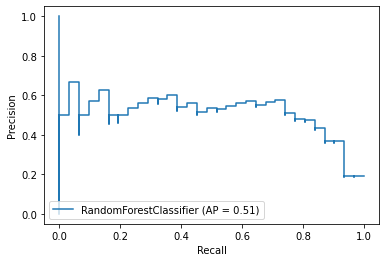

In [54]:
plot_precision_recall_curve(rfbin_best, X_thresh_test, y_thresh_test)

We could potentially improve the recall to about 0.70 if we are willing to accept a drastic decrease in precision to about 0.5 to 0.6. We can look at this another way with the ROC curve.

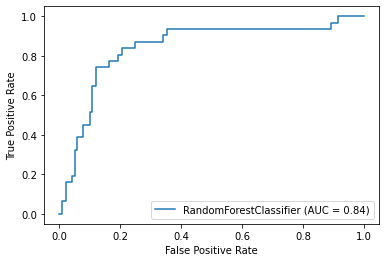

In [55]:
plot_roc_curve(rfbin_best, X_thresh_test, y_thresh_test)

We can generate the precision, recall, and threshold data to select a threshold that better corresponds to the project goals of higher recall.

In [56]:
#predict probabilities
y_bin_probs = rfbin_best.predict_proba(X_thresh_test)
y_probs = y_bin_probs[:,1]

#calculate precision recall curve data and input into df
prec, recall, thr = precision_recall_curve(y_thresh_test, y_probs)
prec = prec[:-1]
recall = recall[:-1]
PR_df = pd.DataFrame({'threshold': thr, 'precision': prec, 'recall': recall})

In [63]:
PR_df[(PR_df['recall'] > 0.6) & (PR_df['precision'] > 0.5)]

,threshold,precision,recall
111,0.349767,0.510638,0.774194
113,0.361907,0.511111,0.741935
114,0.364633,0.522727,0.741935
115,0.390786,0.534884,0.741935
116,0.391383,0.547619,0.741935
117,0.397033,0.560976,0.741935
118,0.422181,0.575000,0.741935
119,0.431238,0.564103,0.709677
120,0.457214,0.552632,0.677419
121,0.466229,0.540541,0.645161


A threshold of 0.422181 improves the precision of the test set to 0.74 while maintaining a precision of above 0.5.

In [64]:
#calculate precision and recall using new threshold with cross validation for year to year comparison
precs = []
recalls = []

for tr_i, te_i in tss.split(X_unscaled):
    
    #make training and testing set
    X_tr, X_te = X_unscaled[tr_i], X_unscaled[te_i]
    y_tr, y_te = y_bin[tr_i], y_bin[te_i]
    
    #train model and predict probabilities on test set
    rfbin_best.fit(X_tr, y_tr)
    y_probs = rfbin_best.predict_proba(X_te)[:,1]
    
    #determine predictions based on probability threshold 
    threshold = 0.422181
    y_pr = np.array([int(i) for i in (y_probs > threshold)])
    
    #score and add scores to lists
    scores = precision_recall_fscore_support(y_te, y_pr)
    precs.append(scores[0][1])
    recalls.append(scores[1][1])
    
print('precisions:', precs)
print('recalls:', recalls)
print('Avg precision:', np.mean(precs), '+ / -', np.std(precs))
print('Avg recall:', np.mean(recalls), '+ / -', np.std(recalls))

precisions: [0.6557377049180327, 0.6666666666666666, 0.6486486486486487]
recalls: [0.6779661016949152, 0.6176470588235294, 0.5454545454545454]
Avg precision: 0.657017673411116 + / - 0.007411296909982276
Avg recall: 0.6136892353243301 + / - 0.05416995729153005


In [81]:
#test the final estimator on the original test set
rfbin_best.fit(X_bin_train, y_bin_train)
y_probs = rfbin_best.predict_proba(X_bin_test)[:,1]
threshold = 0.422181
y_pr = np.array([int(i) for i in (y_probs > threshold)])
pd.DataFrame(precision_recall_fscore_support(y_bin_test, y_pr), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.892473,0.517241
Recall,0.922222,0.428571
Fscore,0.907104,0.468750
Support,180.000000,35.000000


### <a id='5b'>5.b. XGBoost Binary Classifier</a>

In [65]:
#perform randomized hyperparameter search for XGBRegressor
params = {
    'max_depth': [None, 10, 50, 100],
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'min_child_weight': [0.5, 1.0, 3.0, 5.0],
    'gamma': [0, 0.25, 0.5, 1.0],
    'n_estimators': [10, 20, 50, 100],
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1],
    'objective': ['binary:logistic']
}

xgbbin = xgb.XGBClassifier()
xgbbin_cv = RandomizedSearchCV(xgbbin, params, cv=tss, verbose=1, n_jobs=-1, scoring='balanced_accuracy')
xgbbin_cv.fit(X_bin_train, y_bin_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    8.2s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=n...
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=None),
                   n_jobs=-1,
                   param_distrib

In [66]:
pd.DataFrame(xgbbin_cv.cv_results_).sort_values('rank_test_score').T

,8,0,6,1,4,3,2,5,7,9
mean_fit_time,0.417172,0.163292,0.290289,0.217243,0.0508684,0.132717,0.0375066,0.22005,0.073937,0.0432532
std_fit_time,0.190756,0.092117,0.130716,0.116426,0.0110126,0.0699903,0.0134101,0.0930964,0.0375363,0.020533
mean_score_time,0.00378203,0.00414856,0.00405741,0.00394837,0.00648785,0.00433334,0.00340072,0.00381867,0.00342941,0.00463565
std_score_time,0.000457775,0.000121597,0.000166351,0.000117448,0.00245977,0.000325938,9.2009e-05,0.000128069,8.51167e-05,0.0013721
param_objective,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic,binary:logistic
param_n_estimators,100,50,50,50,10,50,10,50,20,10
param_min_child_weight,0.5,5,0.5,3,1,3,5,1,3,3
param_max_depth,100,50,10,50,50,10,None,100,10,10
param_learning_rate,0.3,0.1,0.1,0.1,0.001,0.1,0.01,0.001,0.001,0.001
param_gamma,0.5,0.5,0.5,1,1,0,0.5,1,0.25,1


In [67]:
xgbbin_best = xgbbin_cv.best_estimator_
xgbbin_best.fit(X_bin_train, y_bin_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=100,
              min_child_weight=0.5, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

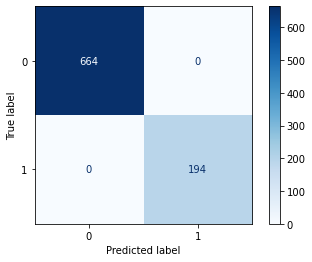

In [68]:
plot_confusion_matrix(xgbbin_best, X_bin_train, y_bin_train, cmap='Blues')
plt.show()

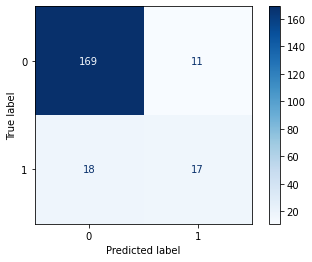

In [69]:
plot_confusion_matrix(xgbbin_best, X_bin_test, y_bin_test, cmap='Blues')
plt.show()

In [70]:
y_xgbbin_pred = xgbbin_best.predict(X_bin_test)
pd.DataFrame(precision_recall_fscore_support(y_bin_test, y_xgbbin_pred), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.903743,0.607143
Recall,0.938889,0.485714
Fscore,0.920981,0.539683
Support,180.000000,35.000000


As with the RF model we can check for consistency using time series split cross-validation.

In [71]:
#check for consistency across unshuffled cross-validation splits
cvs = cross_val_score(xgbbin_best, X_unscaled, y_bin, cv=tss, scoring='recall')
print('Average recall:', np.mean(cvs), '\n' + 'Std recall:' + str(np.std(cvs)))

cvs = cross_val_score(xgbbin_best, X_unscaled, y_bin, cv=tss, scoring='precision')
print('Average precision:', np.mean(cvs), '\n' + 'Std precision:' + str(np.std(cvs)))

Average recall: 0.5266473307350675 
Std recall:0.14504941659753212
Average precision: 0.6567423828222078 
Std precision:0.02256136335362196


The XGBoost binary classifier performs slightly better on our test set than the RF binary regressor with a recall of 0.49, and in cross-validation it has a significantly worse precision (0.66 versus 0.75). The average recall is slightly better than twice the expected recall from the dummy average model.

We can again tune the model to optimize recall.

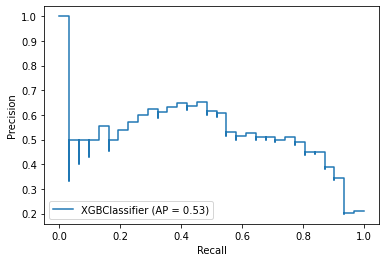

In [72]:
xgbbin_best.fit(X_thresh_train, y_thresh_train)
plot_precision_recall_curve(xgbbin_best, X_thresh_test, y_thresh_test)

It seems we could increase our recall to 0.7 - 0.8 if we are willing to accept a reduced precision of about 0.5. To look at this another way here is the ROC curve.

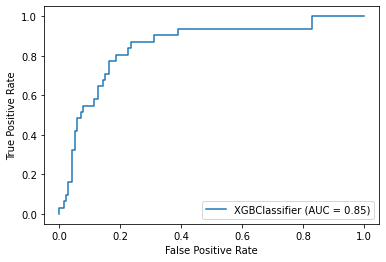

In [73]:
plot_roc_curve(xgbbin_best, X_thresh_test, y_thresh_test)

In [74]:
y_bin_probs = xgbbin_best.predict_proba(X_thresh_test)
y_probs = y_bin_probs[:,1]
prec, recall, thr = precision_recall_curve(y_thresh_test, y_probs)
prec = prec[:-1]
recall = recall[:-1]
PR_df = pd.DataFrame({'threshold': thr, 'precision': prec, 'recall': recall})

In [75]:
PR_df[(PR_df['recall'] > 0.6) & (PR_df['precision'] > 0.5)]

,threshold,precision,recall
93,0.385892,0.510638,0.774194
97,0.398471,0.511628,0.709677
99,0.440468,0.512195,0.677419
101,0.577750,0.512821,0.645161
102,0.590196,0.526316,0.645161
103,0.591945,0.513514,0.612903


A threshold of 0.385892 seems to be promising for obtaining a recall close to 0.8 while maintaining a precision above 0.5.

In [76]:
#calculate precision and recall using new threshold with cross validation for year to year comparison
precs = []
recalls = []

for tr_i, te_i in tss.split(X_unscaled):
    
    #make training and testing set
    X_tr, X_te = X_unscaled[tr_i], X_unscaled[te_i]
    y_tr, y_te = y_bin[tr_i], y_bin[te_i]
    
    #train model and predict probabilities on test set
    xgbbin_best.fit(X_tr, y_tr)
    y_probs = xgbbin_best.predict_proba(X_te)[:,1]
    
    #determine predictions based on probability threshold 
    threshold = 0.385892
    y_pr = np.array([int(i) for i in (y_probs > threshold)])
    
    #score and add scores to lists
    scores = precision_recall_fscore_support(y_te, y_pr)
    precs.append(scores[0][1])
    recalls.append(scores[1][1])
    
print('precisions:', precs)
print('recalls:', recalls)
print('Avg precision:', np.mean(precs), '+ / -', np.std(precs))
print('Avg recall:', np.mean(recalls), '+ / -', np.std(recalls))

precisions: [0.5769230769230769, 0.6323529411764706, 0.5862068965517241]
recalls: [0.7627118644067796, 0.6323529411764706, 0.38636363636363635]
Avg precision: 0.5984943048837571 + / - 0.024239812505132956
Avg recall: 0.5938094806489622 + / - 0.1560420796876709


Overall on cross-validation the XGBoost classifier performs worse than the RF classifier. The RF classifier has an average recall of 0.61 +/- 0.05 compared to the XGBoost recall of 0.59 +/- 0.16. The RF classifier is therefore more sensitive and consistent than the XGBoost classifier. The RF classifier is also more precise, with  an average precision of 0.66 +/- 0.01 versus the XGBoost precision of 0.60 +/- 0.02.

In [80]:
#test the final estimator on the original test set
xgbbin_best.fit(X_bin_train, y_bin_train)
y_probs = xgbbin_best.predict_proba(X_bin_test)[:,1]
threshold = 0.385892
y_pr = np.array([int(i) for i in (y_probs > threshold)])
pd.DataFrame(precision_recall_fscore_support(y_bin_test, y_pr), 
             index=['Precision', 'Recall', 'Fscore', 'Support'])

,0,1
Precision,0.916201,0.555556
Recall,0.911111,0.571429
Fscore,0.913649,0.563380
Support,180.000000,35.000000


The XGBoost performs much better than the RF classifier on our original test set with a recall of 0.57 versus 0.43. 

## <a id='6'>6. Model Recommendation and Feature Importance</a>

Ultimately for the goals of this project we would recommend the binary Random Forest classifier with an adjusted probability threshold in order to increase recall without sacrificing too much precision. Although the XGBoost classifier performed better on our original test set the RF model was more reliable with higher overall performance in cross-validation. Overall this model does provide some ability to predict elevated microcystin concentration up to two weeks in the future based on environmental features, and without using exact site location. 

We can use the SHAP package to explore feature importance in the final model.

In [82]:
#calculate shap values
explainer = shap.Explainer(rfbin_best.predict, X_bin_test)
shap_values = explainer(X_bin_test)

Permutation explainer: 216it [13:03,  3.66s/it]                         


In [83]:
feature_names = unscaled.drop(columns='Particulate Microcystin (µg/L)').columns
shap_values.feature_names = feature_names

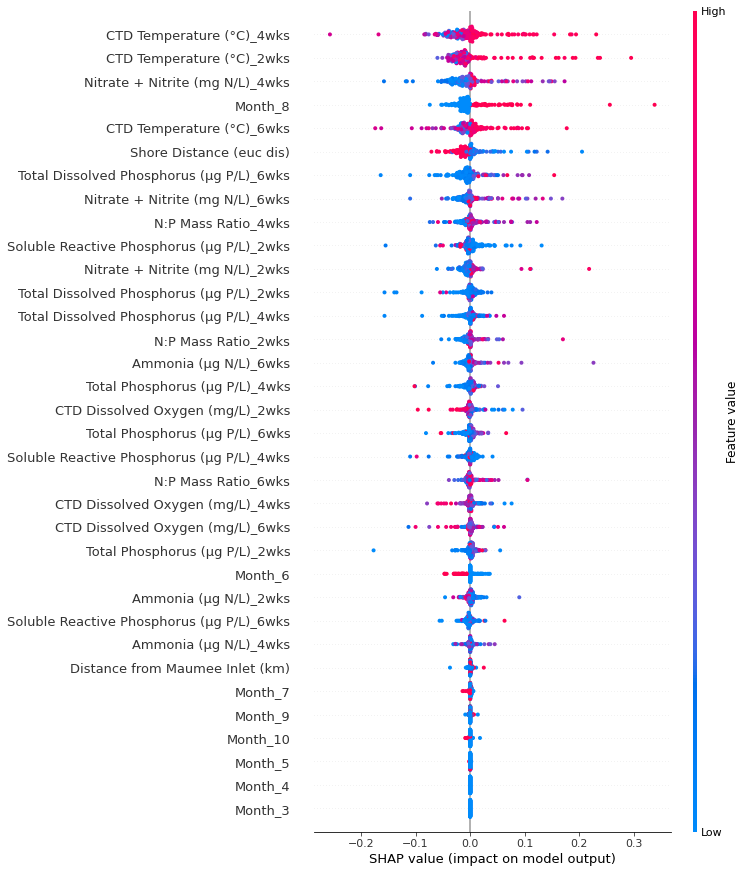

In [84]:
shap.plots.beeswarm(shap_values)

For the most part the feature importance is quite intuitive and in alignment with understanding of what factors promote the growth of harmful algal blooms. High temperatures are quite important, although it is interesting that so many high temperature measurements lower the model output in some cases . More decisive is whether or not the sample is collected in August, which almost universally increases model output. Distance from the Maumee inlet and distance from shore both have quite predictable influence - smaller distances increase model output and vice versa, which is logical since closer sites have more concentrated influx of nutrients coming from the river or agricultural runoff.

The presence of nitrogen-containing nutrients both 4 and 6 weeks prior increases model output, which is logical since these nutrients promote the growth of HABs. It is interesting that nitrogen-containing compounds were more influential than dissolved phosphorus in this case. It is also quite noteworthy that at more distant times, e.g. 4 and 6 weeks in the past, high nitrogen- and phosphorus-containing values increase the model output forecasting HAB presence, but at 2 weeks they do not, or not to the same extent. This would be in line with the time lag concepts explored in the EDA notebook of nutrients peaking prior to HAB formation, but decreasing as the algae grows because the algae consumes the nutrients. 